# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [1]:
# CHECK GPU
!nvidia-smi

Thu Jun 30 11:48:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P8     5W /  N/A |   2401MiB /  4096MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions


In [5]:
# Import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing image of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [7]:
# get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2022-06-30 11:58:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com... 172.217.166.144, 142.250.199.48, 172.217.26.80, ...
Connecting to storage.googleapis.com|172.217.166.144|:443... connected.
ERROR: cannot verify storage.googleapis.com's certificate, issued by `/C=US/O=Google Trust Services LLC/CN=GTS CA 1C3':
  Unable to locally verify the issuer's authority.
ERROR: certificate common name `*.storage.googleapis.com' doesn't match requested host name `storage.googleapis.com'.
To connect to storage.googleapis.com insecurely, use `--no-check-certificate'.
Unable to establish SSL connection.


BadZipFile: File is not a zip file

In [8]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [9]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [11]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [12]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [13]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [14]:
# See an example of a batch of data 
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[ 21.084822    27.084822    27.084822  ]
   [ 21.097895    27.097895    27.097895  ]
   [ 19.909756    25.909756    25.909756  ]
   ...
   [ 93.7019     107.7019     108.7019    ]
   [ 95.73463    109.73463    110.73463   ]
   [ 81.3563      95.3563      96.3563    ]]

  [[ 17.549107    23.549107    22.450893  ]
   [ 17.581314    23.581314    22.483099  ]
   [ 16.43144     22.43144     21.333227  ]
   ...
   [ 79.003235    93.003235    94.003235  ]
   [ 82.74364     96.74364     97.74364   ]
   [ 84.740135    98.740135    99.740135  ]]

  [[ 19.830357    25.830357    23.830357  ]
   [ 19.830357    25.830357    23.830357  ]
   [ 18.61607     24.61607     22.61607   ]
   ...
   [ 77.119545    91.119545    92.119545  ]
   [ 71.41679     85.41679     86.41679   ]
   [ 76.46534     90.46534     91.46534   ]]

  ...

  [[ 79.24846     74.24846     68.24846   ]
   [ 76.32465     71.32465     65.32465   ]
   [ 76.18348     71.464424    64.62159   ]
   ...
   [246.         251.   

## Model 0 : Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequentail order.

But the fucntional API gives us more flexiblity of our models - https://www.tensorflow.org/guide/keras/functional

In [18]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying  pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4.If using model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet's)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations )
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the output into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)), # 25% of test_data
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220630-145337


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 16s 268ms/step - loss: 1.9465 - accuracy: 0.3653 - val_loss: 1.3943 - val_accuracy: 0.6776
Epoch 2/5
24/24 [==============================] - 4s 177ms/step - loss: 1.1660 - accuracy: 0.7360 - val_loss: 0.9170 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 4s 177ms/step - loss: 0.8510 - accuracy: 0.8080 - val_loss: 0.7460 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - 4s 177ms/step - loss: 0.6959 - accuracy: 0.8307 - val_loss: 0.6566 - val_accuracy: 0.8174
Epoch 5/5
24/24 [==============================] - 4s 178ms/step - loss: 0.6005 - accuracy: 0.8493 - val_loss: 0.6037 - val_accuracy: 0.8339


In [19]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6249 - accuracy: 0.8348


[0.6248597502708435, 0.8348000049591064]

In [20]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [21]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

In [22]:
#  How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


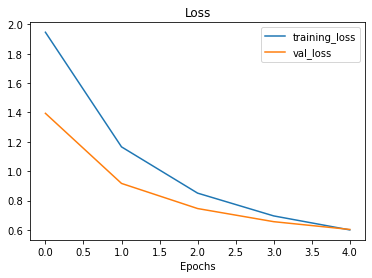

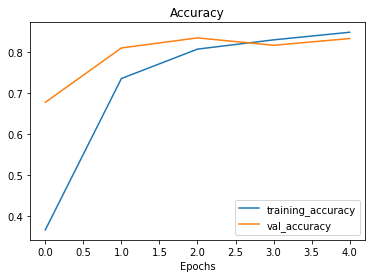

In [23]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector for a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [27]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [28]:
# Let's replicate the GlobalAverage2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer `(tf.keras.layers.Dense())`, it also condenses the information found by the base model into a lower dimension **feature vector**.

**Note**: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of.

**Practice**: Do the same as the above cell but for `tf.keras.layers.GlobalMaxPool2D()`.

In [33]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global Max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global Max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


In [34]:
# Let's replicate the GlobalAverage2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Looks like `tf.keras.layers.GlobalMaxPool2D()` is return max random tensor number

## Running a series of transfer learning experiments

We've seen the increadible results transfer learning can get with inly 10% of the training data, but how does it go with 1% of the training data... how about we setup a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the traiining data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> **NOTE:** thoughtout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing for model_1

In [40]:
# Download and unzip data - preprocessed from Food101
import urllib.request
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip'
filename = '10_food_classes_1_percent.zip'
urllib.request.urlretrieve(url, filename)

#  unzip data
unzip_data(filename)

In [41]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [42]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [43]:
# setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE,
                                                                          label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE,
                                                               label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation:https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmentating them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
#     preprocessing.Rescale(1/255.) # Keep for models like ResNet50V2 but EfficientNet has Rescling built-in layers
], name="data_augmentation")

### Visualize our data augmentation layers(and see what happens to our data)

10_food_classes_1_percent/train/hamburger/1928916.jpg


(-0.5, 493.5, 335.5, -0.5)

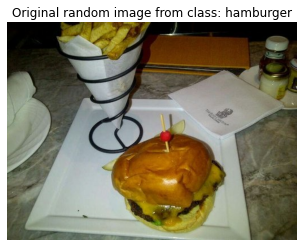

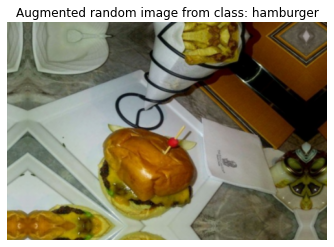

In [67]:
# view a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

# Read the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [70]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and output
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25 * len(test_data)),
                               # Track model training logs
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220630-164507
Epoch 1/5


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - ETA: 0s - loss: 2.4214 - accuracy: 0.0857WARNING:tensorflow:Model was constructed with shape (None, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 512, 3), dtype=tf.uint8, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


3/3 [==============================] - 10s 2s/step - loss: 2.4214 - accuracy: 0.0857 - val_loss: 2.2361 - val_accuracy: 0.1776
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1635 - accuracy: 0.3286 - val_loss: 2.1123 - val_accuracy: 0.2401
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9759 - accuracy: 0.4429 - val_loss: 2.0184 - val_accuracy: 0.3158
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8155 - accuracy: 0.5143 - val_loss: 1.9331 - val_accuracy: 0.3651
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.6730 - accuracy: 0.6571 - val_loss: 1.8508 - val_accuracy: 0.4194


In [71]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, 3)           0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [73]:
# Evaluate on the full test dataset
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 8s 95ms/step - loss: 1.8230 - accuracy: 0.4548


[1.823020100593567, 0.454800009727478]

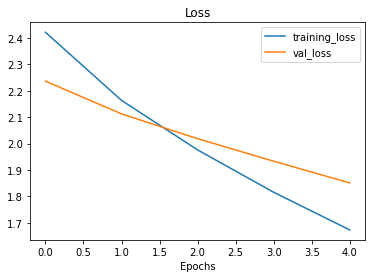

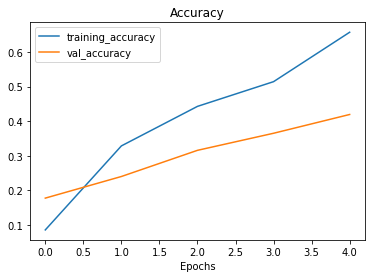

In [74]:
# How do  the model with 1% of the data and with data augmentation loss curves?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning with 10% of data and data augmentatioin

In [78]:
# get 10% of data...

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

In [79]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [81]:
# Set data input
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data  = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [85]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.25)
], name="data_augmentation")

# setup the input shape to our model
input_shape = (224, 224, 3)

# create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augmentation our traning data
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layesr don't get updated - https://keras.io/guides/transfer_learning/
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

### Creating model checkpoint callbacks

The ModelCheckpoint callback intermediately saves our model (the full model or just the weight) during training. This is useful so we can come and start where we left off.

In [88]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weight/checkpoint.ckpt"

# create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True,
                                                        save_freq="epoch", # save every epoch
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [91]:
# Fit the model saving checkpoint every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220630-183124
Epoch 1/5


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 22s 758ms/step - loss: 2.0121 - accuracy: 0.3427 - val_loss: 1.5086 - val_accuracy: 0.6414

Epoch 00001: val_loss improved from inf to 1.50859, saving model to ten_percent_model_checkpoint_weight\checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 13s 527ms/step - loss: 1.3930 - accuracy: 0.6293 - val_loss: 1.1030 - val_accuracy: 0.7237

Epoch 00002: val_loss improved from 1.50859 to 1.10302, saving model to ten_percent_model_checkpoint_weight\checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 13s 553ms/step - loss: 1.1040 - accuracy: 0.7360 - val_loss: 0.8984 - val_accuracy: 0.7664

Epoch 00003: val_loss improved from 1.10302 to 0.89836, saving model to ten_percent_model_checkpoint_weight\checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 10s 399ms/step - loss: 0.9264 - accuracy: 0.7747 - val_loss: 0.7808 - val_accuracy: 0.7862

Epoch 00004: val_loss improved from 0.89836 to 0.78084, saving model t

In [92]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 8s 96ms/step - loss: 0.6249 - accuracy: 0.8348


[0.6248597502708435, 0.8348000049591064]

In [94]:
# Check model_2 result on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 8s 96ms/step - loss: 0.7155 - accuracy: 0.8112


[0.7154952883720398, 0.8112000226974487]

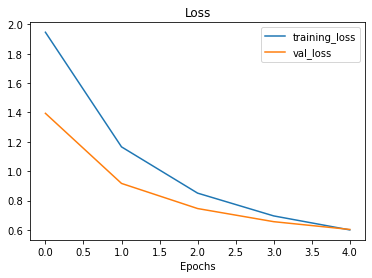

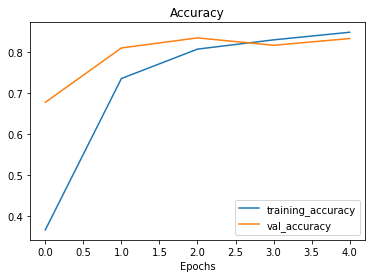

In [96]:
# plot model loss curves
plot_loss_curves(history_10_percent)

### Loadding in checkpointed weights

Loading in checkpointed weights returns a model to specific checkpoint.

In [98]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [99]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 8s 94ms/step - loss: 0.7155 - accuracy: 0.8112


In [100]:
# If the result from our previously evaluated model_2 match the loaded weights, everything has work.
results_10_percent_data_aug == loaded_weights_model_results

False

In [101]:
results_10_percent_data_aug

[0.7154952883720398, 0.8112000226974487]

In [102]:
loaded_weights_model_results

[0.7154951691627502, 0.8112000226974487]

In [103]:
# Check to see if loaded model results are very close to our previious non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [104]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


# Model 3: Fine-tuning an existing model on 10% of the data

> **NOTE:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [105]:
# layer in loaded model
model_2.layers

In [106]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001DF641B3978> True
<keras.engine.sequential.Sequential object at 0x000001DF67D0CFD0> True
<keras.engine.functional.Functional object at 0x000001DF708BB4A8> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x000001DF708760B8> True
<keras.layers.core.Dense object at 0x000001DF4186E278> True


In [109]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))  # layer at index 2 is the EfficientNetB0 layer (the base model)

0


We can even check layer by layer to see if the they're trainable.

In [108]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

> **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire base model by setting its `trainable` attribute to `True`. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their `trainable` attribute to `False`. Finally, we'll recompile the model.

In [111]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we mmake a change)
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(lr=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
               metrics=["accuracy"])

C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [113]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [114]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variable are there?
print(len(model_2.trainable_variables))

12


In [116]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs=fine_tune_epochs,
                                              validation_data=test_data,
                                              validation_steps=int(0.25 * len(test_data)),
                                              initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epochs
                                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220630-225654
Epoch 5/10


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 21s 632ms/step - loss: 0.7426 - accuracy: 0.7800 - val_loss: 0.5703 - val_accuracy: 0.8273
Epoch 6/10
24/24 [==============================] - 11s 462ms/step - loss: 0.5963 - accuracy: 0.8173 - val_loss: 0.5418 - val_accuracy: 0.8174
Epoch 7/10
24/24 [==============================] - 11s 463ms/step - loss: 0.5117 - accuracy: 0.8280 - val_loss: 0.5452 - val_accuracy: 0.8207
Epoch 8/10
24/24 [==============================] - 11s 455ms/step - loss: 0.5107 - accuracy: 0.8307 - val_loss: 0.5452 - val_accuracy: 0.8109
Epoch 9/10
24/24 [==============================] - 11s 470ms/step - loss: 0.4310 - accuracy: 0.8667 - val_loss: 0.5348 - val_accuracy: 0.8158
Epoch 10/10
24/24 [==============================] - 9s 390ms/step - loss: 0.4290 - accuracy: 0.8667 - val_loss: 0.4985 - val_accuracy: 0.8306


In [119]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 94ms/step - loss: 0.5094 - accuracy: 0.8276


In [120]:
results_10_percent_data_aug

[0.7154952883720398, 0.8112000226974487]

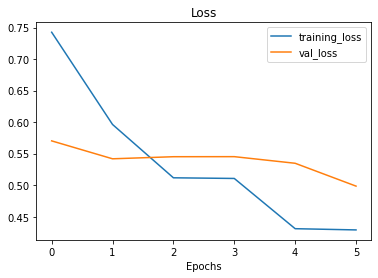

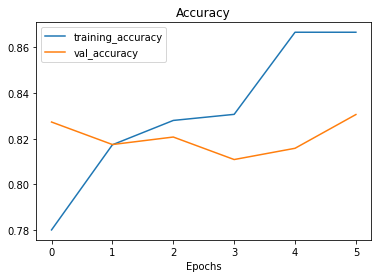

In [121]:
# check out the loss curves of our fine-tune model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want somthing to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [123]:
# let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow history objects.
    """
    # get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    # Combine original history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    
    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    
    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

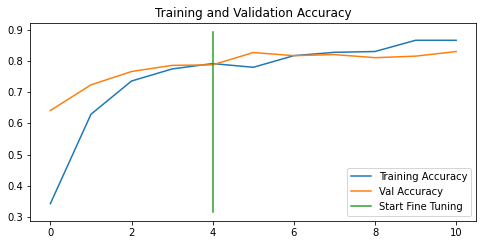

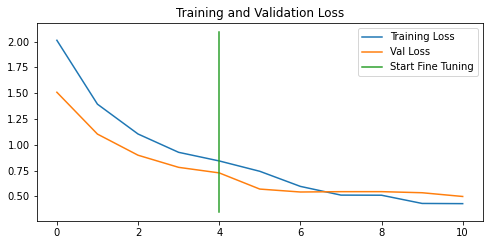

In [124]:
compare_historys(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs=5)

# Model 4: Fine-tuning and existing model on all of the data

In [125]:
# Download and unzip data - preprocessed from Food101
import urllib.request
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip'
filename = '10_food_classes_all_data.zip'
urllib.request.urlretrieve(url, filename)

#  unzip data
unzip_data(filename)

In [126]:
# setup training and test dir
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [127]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [128]:
# setup data input
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE,
                                                               label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loadded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset)

In [129]:
# Evaluate the model 2 (this is the fine-tuned on 10 percet of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 8s 95ms/step - loss: 0.5094 - accuracy: 0.8276


[0.509421169757843, 0.8276000022888184]

In [130]:
results_fine_tune_10_percent

[0.5094212889671326, 0.8276000022888184]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [131]:
# Load weights from checkpoint, that way we can fine-tune from 
# the samme stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [132]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 8s 95ms/step - loss: 0.7155 - accuracy: 0.8112


[0.7154952883720398, 0.8112000226974487]

In [133]:
# Check to see if our model_2 has been reverted back to feature extration results
results_10_percent_data_aug

[0.7154952883720398, 0.8112000226974487]

The previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved model's weights using `ModelCheckpoint` callback.
2. Fine-Tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [134]:
# Check witch layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [135]:
# Let's drill into our base_model (EfficientNetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [136]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(lr=0.0001),
               metrics=["accuracy"])

C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [137]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs  = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          initial_epoch=history_10_percent_data_aug.epoch[-1],
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220701-091452
Epoch 5/10


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 53s 205ms/step - loss: 0.7461 - accuracy: 0.7599 - val_loss: 0.4271 - val_accuracy: 0.8635
Epoch 6/10
235/235 [==============================] - 64s 271ms/step - loss: 0.6071 - accuracy: 0.8041 - val_loss: 0.3592 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - 60s 255ms/step - loss: 0.5580 - accuracy: 0.8168 - val_loss: 0.3565 - val_accuracy: 0.8882
Epoch 8/10
235/235 [==============================] - 56s 237ms/step - loss: 0.5001 - accuracy: 0.8413 - val_loss: 0.3657 - val_accuracy: 0.8898
Epoch 9/10
235/235 [==============================] - 52s 219ms/step - loss: 0.4642 - accuracy: 0.8535 - val_loss: 0.3334 - val_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 50s 210ms/step - loss: 0.4401 - accuracy: 0.8611 - val_loss: 0.2899 - val_accuracy: 0.9161


In [138]:
# Let's evaluate on all of the test_data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 8s 94ms/step - loss: 0.3234 - accuracy: 0.8968


[0.3233560621738434, 0.8967999815940857]

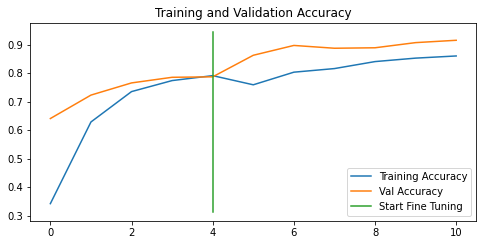

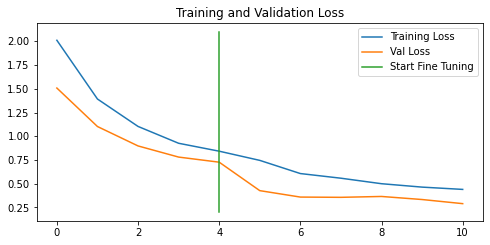

In [139]:
# How did fine-tuning go with more data ?
compare_historys(original_history=history_10_percent_data_aug,
                new_history=history_fine_10_classes_full,
                initial_epochs=5)

## Viewing our experiment data on TensorBoard

> **NOTE:** Anything you upload to Tensorboard.dev is goin to be public. So if you have private data, do not upload 

In [ ]:
!tensorboard dev list

In [143]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./trainsfer_learning \
    --name "Transfer learning Experiments with 10 Food101 Classes" \
    --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
    --one_shot 

^C
